In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
from scipy import signal
from scipy.fftpack import ifft, fftshift
import math, os
import dftModel as DFT
import utilFunctions as UF
import sineModel as SM

In [3]:
def sineModelMultiResAnal(x, fs, ws, Ns, Bs, H, t, 
                            minSineDur=0.02, maxnSines=150, freqDevOffset=10, freqDevSlope=0.001):
    hsN = H/2
    pend = x.size
    pin = max([hsN] + [int(math.floor((w.size+1)/2)) for w in ws])
    x = np.append(np.zeros(pin),x)
    x = np.append(x,np.zeros(pin))
    
    def dftAnal(p, w, N, B):
        hM1 = int(math.floor((w.size+1)/2))
        hM2 = int(math.floor(w.size/2))
        x1 = x[p-hM1:p+hM2]
        fftbuffer = np.zeros(N)
        rw = w / sum(w)
        mX, pX = DFT.dftAnal(x1, rw, N)
        
        upperIndex = Bs.index(B)
        lower_bin = 1
        if upperIndex > 0:
            lower_bin = int(np.ceil(float(Bs[upperIndex-1])*N/fs))
        upper_bin = int(np.ceil(float(B)*N/fs))
        
        ploc = UF.peakDetection(mX, t)
        # Peak choice
        ploc = ploc[np.logical_and(ploc > lower_bin, ploc <= upper_bin)]
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)
        ipfreq = fs*iploc/float(N)

        return (ipfreq, ipmag, ipphase)

    xtfreq = np.array([])
    xtmag = np.array([])
    xtphase = np.array([])
    tfreq = np.array([])
    while pin <= pend:
        
        pfs = np.array([])
        pms = np.array([])
        pps = np.array([])

        for i, w in enumerate(ws):
            pf, pm, pp = dftAnal(pin, w, Ns[i], Bs[i])
            pfs = np.concatenate((pfs, pf))
            pms = np.concatenate((pms, pm))
            pps = np.concatenate((pps, pp))
        
        tfreq, tmag, tphase = SM.sineTracking(pfs, pms, pps, tfreq, freqDevOffset, freqDevSlope)
        tfreq = np.resize(tfreq, min(maxnSines, tfreq.size))
        tmag = np.resize(tmag, min(maxnSines, tmag.size))
        tphase = np.resize(tphase, min(maxnSines, tphase.size))
        jtfreq = np.zeros(maxnSines)
        jtmag = np.zeros(maxnSines)
        jtphase = np.zeros(maxnSines)
        jtfreq[:tfreq.size]=tfreq
        jtmag[:tmag.size]=tmag
        jtphase[:tphase.size]=tphase

        if xtfreq.size == 0:
            xtfreq = jtfreq
            xtmag = jtmag
            xtphase = jtphase
        else:
            xtfreq = np.vstack((xtfreq, jtfreq))
            xtmag = np.vstack((xtmag, jtmag))
            xtphase = np.vstack((xtphase, jtphase))
        
        pin += H
        
    xtfreq = SM.cleaningSineTracks(xtfreq, round(fs*minSineDur/H))  
    return xtfreq, xtmag, xtphase

In [4]:
def sineModelMultiRes(inputFile="../../sounds/orchestra.wav", 
                    windows=(signal.blackman(4095), signal.hamming(2047), np.hamming(1023)),
                    Ns=(4096, 2048, 1024), 
                    Bs=(1000, 5000, 22050), 
                    t=-80, minSineDur=0.02, 
                    maxnSines=150, freqDevOffset=10, freqDevSlope=0.001, PlotIt=True):
    
    sN = 512
    H = sN/4
    (fs, x) = UF.wavread(inputFile)
    
    tfreq, tmag, tphase = sineModelMultiResAnal(x, fs, windows, Ns, Bs, H, t, 
                            minSineDur, maxnSines, freqDevOffset, freqDevSlope)
    y = SM.sineModelSynth(tfreq, tmag, tphase, sN, H, fs)
    
    # calculate diff between x & y
    diffLength = min([x.size, y.size])
    diff = np.abs(x[:diffLength] - y[:diffLength])
    print("diff {0}".format(np.sum(diff)))
    
    outputFile = os.path.basename(inputFile)[:-4] + '_sineModelMulti.wav'
    UF.wavwrite(y, fs, outputFile)
    
    if not PlotIt:
        return
    
    plt.figure(figsize=(12, 9))

    maxplotfreq = 10000.0

    # plot the input sound
    plt.subplot(3,1,1)
    plt.plot(np.arange(x.size)/float(fs), x)
    plt.axis([0, x.size/float(fs), min(x), max(x)])
    plt.ylabel('amplitude')
    plt.xlabel('time (sec)')
    plt.title('input sound: x')

    # plot the sinusoidal frequencies
    plt.subplot(3,1,2)
    if (tfreq.shape[1] > 0):
        numFrames = tfreq.shape[0]
        frmTime = H*np.arange(numFrames)/float(fs)
        tfreq[tfreq<=0] = np.nan
        plt.ylabel('frequency (Hz)')
    	plt.xlabel('time (sec)')
    	plt.title('input sound: x')
        plt.plot(frmTime, tfreq)
        plt.axis([0, x.size/float(fs), 0, maxplotfreq])
        plt.title('frequencies of sinusoidal tracks')

    # plot the output sound
    plt.subplot(3,1,3)
    plt.plot(np.arange(y.size)/float(fs), y)
    plt.axis([0, y.size/float(fs), min(y), max(y)])
    plt.ylabel('amplitude')
    plt.xlabel('time (sec)')
    plt.title('output sound: y')

    plt.tight_layout()
    plt.show()


diff 12754.650202


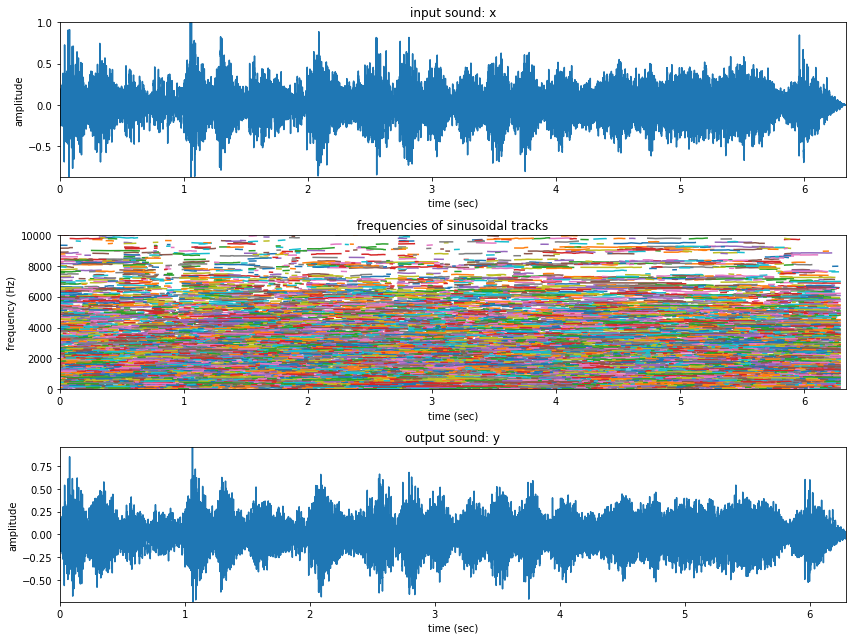

In [5]:
if __name__ == "__main__":
    w = [signal.blackman(4095), signal.blackman(4095), np.blackman(4095)]
    n = [4096, 4096, 4096]
    b = [1000, 4000, 22050]
    
    sineModelMultiRes(windows=w,Ns=n,Bs=b)